In [14]:
%pip install -Uqq fastai

Note: you may need to restart the kernel to use updated packages.


In [15]:
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(item, max_images=30):
    print(f"Searching for '{item}'")
    with DDGS() as ddgs:
        # generator which yields dicts with:
        # {'title','image','thumbnail','url','height','width','source'}
        search_results = ddgs.images(keywords=item)       
        # grap number of max_images urls
        image_urls = []

        # Iterate through the first 'max_images' items in 'search_results'
        for i in range(max_images):
            try:
                result = next(search_results)
                image_urls.append(result.get("image"))
            except StopIteration:
                break
        
        #image_urls = [next(search_results).get("image") for i in range(max_images)]
        # convert to L (functionally extended list class from fastai)
        return L(image_urls)

In [16]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('bird photos', max_images=1)
num = 1
for i in urls:
    print(f"{num}: {i}")
    num = num+1

Searching for 'bird photos'
1: https://images.pexels.com/photos/1661179/pexels-photo-1661179.jpeg?cs=srgb&dl=green-bird-1661179.jpg&fm=jpg


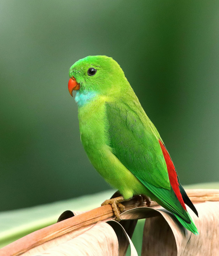

In [17]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'forest photos'


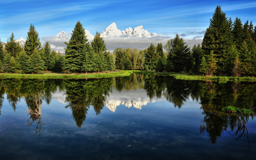

In [18]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

In [19]:
searches = 'forest','bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(2)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(2)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(2)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'


In [20]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)
print(f"Total Failed: {len(failed)}")

Total Failed: 2


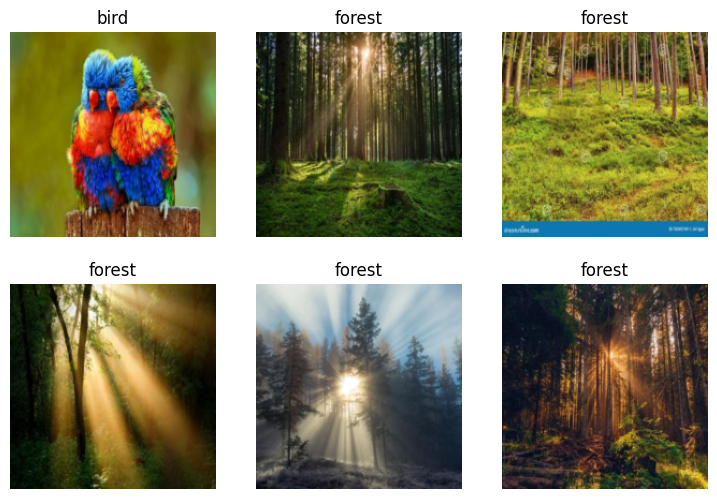

In [21]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [22]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.518859,0.050297,0.027397,00:12


epoch,train_loss,valid_loss,error_rate,time
0,0.049687,0.005122,0.000000,00:15
1,0.034269,0.000660,0.000000,00:15
2,0.032694,0.000436,0.000000,00:15


In [23]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000
